# House Price Prediction Model

Before running this notebook, be sure run [Data Wrangling](data_wrangling.ipynb) jupyter notebook to obtain the dataset for training the model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
sns.set()
%matplotlib inline

In [2]:
# load data
df_data = pd.read_pickle('data/house_price_w_temp.pkl')
df_data.head()

,Division,Region,State,State Code,City,Year,Month,StateAvgYearlyTemp,CityAvgYearlyTemp,AvgHousePrice,...,State__South Dakota,State__Tennessee,State__Texas,State__Utah,State__Vermont,State__Virginia,State__Washington,State__West Virginia,State__Wisconsin,State__Wyoming
0,Pacific,West,Alaska,AK,Anchorage,1996,1,35.700792,37.416278,124475.0,...,0,0,0,0,0,0,0,0,0,0
1,East South Central,South,Alabama,AL,Auburn,1996,1,63.960195,NaN,129520.0,...,0,0,0,0,0,0,0,0,0,0
2,East South Central,South,Alabama,AL,Autaugaville,1996,1,63.960195,NaN,79769.0,...,0,0,0,0,0,0,0,0,0,0
3,East South Central,South,Alabama,AL,Bay Minette,1996,1,63.960195,NaN,59125.0,...,0,0,0,0,0,0,0,0,0,0
4,East South Central,South,Alabama,AL,Berry,1996,1,63.960195,NaN,65718.0,...,0,0,0,0,0,0,0,0,0,0


## House Price Model Class

In [3]:
class HousePriceModel:
    
    def __init__(self, model_name, param, features):
        self.model_name = model_name
        pipe = Pipeline(steps=[('scaler', StandardScaler()), ('rf', RandomForestRegressor(random_state=42))])
        self.model = GridSearchCV(estimator=pipe, param_grid=param, cv=3, n_jobs=-1, verbose=2)
        self.features = features
        self.feature_imp = self.metrics = None
        self.y_predict = self.y_error = None
    
    def evaluate(self, X_train, y_train, X_test, y_test):
        self.y_train = y_train
        start_time = time.time()
        self.model.fit(X_train, y_train)
        stop_time = time.time()
        self.y_predict = np.round(self.model.predict(X_test), 1)
        self.y_error = self.y_predict - y_test
        mse = mean_squared_error(y_test, self.y_predict)
        metrics_dict = {'model_name': self.model_name,
                        'mse': mse,             # mean squared error
                        'rmse': np.sqrt(mse),   # relative mean squared error
                        'mae': mean_absolute_error(y_test, self.y_predict),     # mean absolute error
                        'R-squared': self.model.score(X_train, y_train),
                        'training_time': stop_time - start_time}  
        self.metrics = pd.DataFrame(metrics_dict, index=[0])
        
        # sort feature importance in descending order
        self.feature_imp = pd.Series(self.model.best_estimator_._final_estimator.feature_importances_, 
                                index=self.features).sort_values(ascending=False)
    
    def plot_feature_importance(self, figsize=(6, 6)):
        fig, ax = plt.subplots(figsize=figsize)
        
        # create a bar plot of feature importance
        sns.barplot(x=self.feature_imp, y=self.feature_imp.index)

        # add labels to graph
        plt.xlabel('Score', size=13)
        plt.ylabel('Features', size=13)
        plt.title('Feature Importance', size=15)
        plt.show()

## Split Data intro Train/Validation/Test

In [4]:
from sklearn.model_selection import train_test_split

y = df_data['AvgHousePrice']   # target variable
X = df_data[df_data.columns[5:]].drop(['AvgHousePrice', 'CityAvgYearlyTemp'], axis=1)   # predictors

# split data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

## Base Model

In [5]:
param = {'rf__n_estimators': [5]}
base_model = HousePriceModel('base_model', param, list(X_train.columns))
base_model.evaluate(X_train, y_train, X_test, y_test)
base_model.metrics

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.7min finished


,model_name,mse,rmse,mae,R-squared,training_time
0,base_model,2.909712e+10,170578.770877,76129.417926,0.222031,328.506797


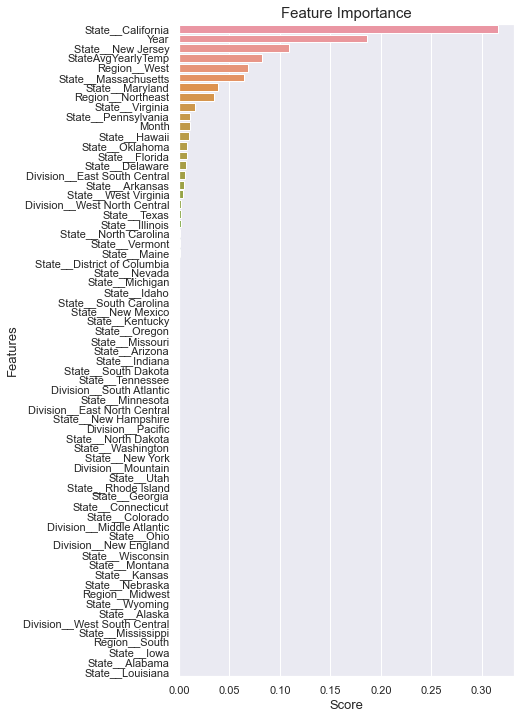

In [6]:
base_model.plot_feature_importance((6,12))

## Model with Less Features

In [7]:
# exclude states from the model
features = X_train.columns[:16]
model1 = HousePriceModel('model 1', param, list(features))
model1.evaluate(X_train[features], y_train, X_test[features], y_test)
model1.metrics

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   42.6s finished


,model_name,mse,rmse,mae,R-squared,training_time
0,model 1,2.909714e+10,170578.83654,76130.008015,0.222031,91.245705


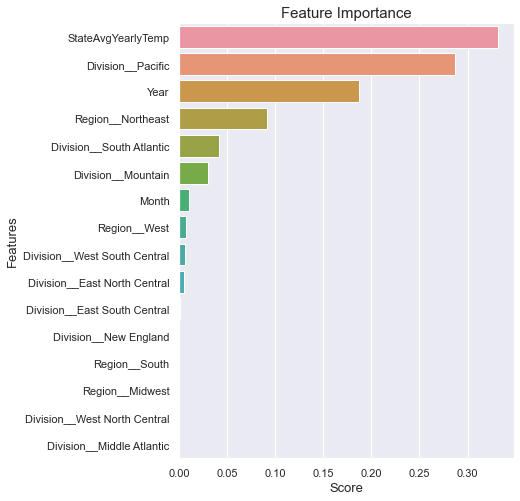

In [8]:
model1.plot_feature_importance((6,8))

## Model's Prediction

In [9]:
import pickle

# load df_states for information lookup
df_states = pickle.load(open('web_app/df_states.sav', 'rb'))
df_states.head()

,State,State Code,Region,Division,StateAvgYearlyTemp
0,Alaska,AK,West,Pacific,35.700792
1,Alabama,AL,South,East South Central,63.960195
2,Arkansas,AR,South,West South Central,61.796613
3,Arizona,AZ,West,Mountain,68.692714
4,California,CA,West,Pacific,61.485810


In [10]:
# now look for the states having temperature in the specified range
min_temp = 60
max_temp = 75

# get all states having the avg yearly temperature in range
temp = df_states[(df_states.StateAvgYearlyTemp >= min_temp) & (df_states.StateAvgYearlyTemp <= max_temp)]
temp

,State,State Code,Region,Division,StateAvgYearlyTemp
1,Alabama,AL,South,East South Central,63.960195
2,Arkansas,AR,South,West South Central,61.796613
3,Arizona,AZ,West,Mountain,68.692714
4,California,CA,West,Pacific,61.485810
9,Florida,FL,South,South Atlantic,71.599247
10,Georgia,GA,South,South Atlantic,64.144951
18,Louisiana,LA,South,West South Central,67.645479
25,Mississippi,MS,South,East South Central,63.203840
33,Nevada,NV,West,Mountain,61.743211
36,Oklahoma,OK,South,West South Central,60.448711


In [11]:
# perform one-hot-encodings
temp = pd.concat([temp, pd.get_dummies(temp['Region'], prefix='Region_')], axis=1)
temp = pd.concat([temp, pd.get_dummies(temp['Division'], prefix='Division_')], axis=1)
temp.head()

,State,State Code,Region,Division,StateAvgYearlyTemp,Region__South,Region__West,Division__East South Central,Division__Mountain,Division__Pacific,Division__South Atlantic,Division__West South Central
1,Alabama,AL,South,East South Central,63.960195,1,0,1,0,0,0,0
2,Arkansas,AR,South,West South Central,61.796613,1,0,0,0,0,0,1
3,Arizona,AZ,West,Mountain,68.692714,0,1,0,1,0,0,0
4,California,CA,West,Pacific,61.485810,0,1,0,0,1,0,0
9,Florida,FL,South,South Atlantic,71.599247,1,0,0,0,0,1,0


In [12]:
temp.shape

(13, 12)

In [13]:
# build inputs data frame for house price estimate
inputs = pd.DataFrame(columns=features)

for feature in features:
    if feature in list(temp.columns[4:]):
        inputs[feature] = temp[feature]

# fill in month and year
inputs['Month'] = 3
inputs['Year'] = 2021

# fill missing values with 0
inputs.fillna(0, inplace=True)
inputs.head()

,Year,Month,StateAvgYearlyTemp,Region__Midwest,Region__Northeast,Region__South,Region__West,Division__East North Central,Division__East South Central,Division__Middle Atlantic,Division__Mountain,Division__New England,Division__Pacific,Division__South Atlantic,Division__West North Central,Division__West South Central
1,2021,3,63.960195,0,0,1,0,0,1,0,0,0,0,0,0,0
2,2021,3,61.796613,0,0,1,0,0,0,0,0,0,0,0,0,1
3,2021,3,68.692714,0,0,0,1,0,0,0,1,0,0,0,0,0
4,2021,3,61.485810,0,0,0,1,0,0,0,0,0,1,0,0,0
9,2021,3,71.599247,0,0,1,0,0,0,0,0,0,0,1,0,0


In [14]:
inputs.shape

(13, 16)

In [15]:
# build outputs table
outputs = pd.DataFrame(columns=['State', 'StateAvgYearlyTemp', 'PredictedPrice'])
outputs['State'] = temp['State']
outputs['StateAvgYearlyTemp'] = inputs['StateAvgYearlyTemp']
outputs['PredictedPrice'] = np.round(model1.model.predict(inputs), 2)
outputs

,State,StateAvgYearlyTemp,PredictedPrice
1,Alabama,63.960195,118958.67
2,Arkansas,61.796613,93364.80
3,Arizona,68.692714,245280.83
4,California,61.485810,579828.03
9,Florida,71.599247,307557.36
10,Georgia,64.144951,159283.92
18,Louisiana,67.645479,131744.54
25,Mississippi,63.203840,109996.42
33,Nevada,61.743211,252116.10
36,Oklahoma,60.448711,92789.25


## Save Model

In [16]:
pickle.dump(model1, open('web_app/model.sav', 'wb'))  # save model